<a href="https://colab.research.google.com/github/its-rajesh/Pattern-Recognition/blob/main/PRA1Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Activity Detection**

You are going to perform speech activity detection (SAD.) Given a sequence of signal frames, classify each frame as speech or non-speech.
Two types of 1-D features are provided: short-time energy, and Melfilterbank energy. Which of these features are better at correctly detecting speech? Plot ROC curves to justify your choice.

• You can use a simple unimodal Gaussian to estimate the distribution of the features. Use sample mean and sample variance as
parameters of the Gaussian.

• The ground truth files are provided with 1 meaning speech and 0
meaning non-speech.

• Use Segment 2 for estimating the model and segment 3 for testing
(ie ROC curves will be computed on Segment 3.)

• Refer to ROC curves in Duda’s textbook (Sec 2.8.3)

### Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


### Reading Training, Testing and Ground Truth

In [24]:
path = '/drive/My Drive/Pattern Recognition/Assignment1/assign1_data/q1/'
files = os.listdir(path)

In [19]:
train_ste = pd.read_csv(path+'Segment2_STEnergy.csv', header=None)
train_mel = pd.read_csv(path+'Segment2_MelEnergy.csv', header=None)
train_gt = pd.read_csv(path+'Segment2_VAD_GT.csv', header = None)

train_ste.shape, train_mel.shape, train_gt.shape

((256, 1), (256, 1), (256, 1))

In [21]:
test_ste = pd.read_csv(path+'Segment3_STEnergy.csv', header=None)
test_mel = pd.read_csv(path+'Segment3_MelEnergy.csv', header=None)
test_gt = pd.read_csv(path+'Segment3_VAD_GT.csv', header=None)

test_ste.shape, test_mel.shape, test_gt.shape

((275, 1), (275, 1), (275, 1))

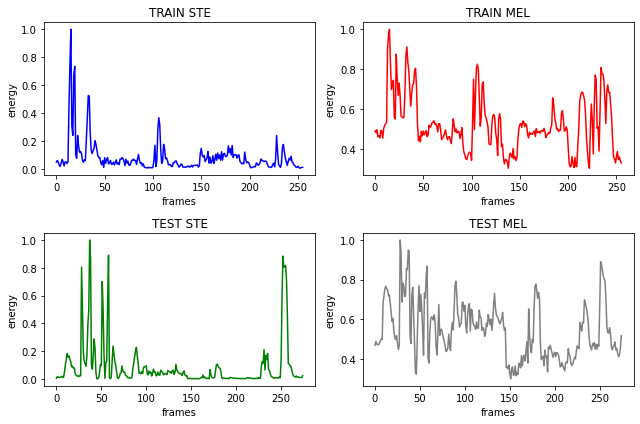

In [56]:
plt.subplot(2, 2, 1)
plt.plot(train_ste, 'blue')
plt.title("TRAIN STE")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 2)
plt.plot(train_mel, 'red')
plt.title("TRAIN MEL")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 3)
plt.plot(test_ste, 'green')
plt.title("TEST STE")
plt.xlabel('frames')
plt.ylabel('energy')

plt.subplot(2, 2, 4)
plt.plot(test_mel, 'gray')
plt.title("TEST MEL")
plt.xlabel('frames')
plt.ylabel('energy')

plt.tight_layout(rect=(0, 0, 1.5, 1.5))
plt.show()

### Some Useful functions for both STE and MEL

In [68]:
def extract_features(val, gt):
  speech, nonspeech = [], []
  for i in range(len(gt)):
    if gt[i] == 1:
      speech.append(val[i])
    else:
      nonspeech.append(val[i])
  return np.array(speech), np.array(nonspeech)

In [134]:
def probability(x):
  n = len(x)

  return 0

In [133]:
def probability_x_given_y(x, y):
  x_and_y = y.copy()
  x_and_y.append(x)
  py = probability(y)

  return 0


probability_x_given_y(0.0178719525, list(ste_speech))

0.0178719525 111
111 112


0

## **STE Based Detection**

In [113]:
ste_speech, ste_nonspeech = extract_features(train_ste[0], train_gt[0])

### Maximum Likelihood Estimate

In [76]:
ste_mean_s = np.mean(ste_speech)
ste_mean_ns = np.mean(ste_nonspeech)

ste_var_s = np.var(ste_speech)
ste_var_ns = np.var(ste_nonspeech)

print('Speech:\nmean = {}\nvariance = {}'.format(ste_mean_s, ste_var_s))
print('Non Speech:\nmean = {}\nvariance = {}'.format(ste_mean_ns, ste_var_ns))

Speech:
mean = 0.12043432332432433
variance = 0.027681259243278893
Non Speech:
mean = 0.053090674108275865
variance = 0.0012944035189149682


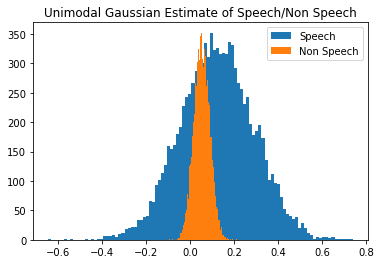

In [137]:
ste_plot_s = np.random.normal(ste_mean_s, np.sqrt(ste_var_s), 10000)
ste_plot_ns = np.random.normal(ste_mean_ns, np.sqrt(ste_var_ns), 10000)

plt.hist(ste_plot_s, bins=100)
plt.hist(ste_plot_ns, bins=100)

plt.title('Unimodal Gaussian Estimate of Speech/Non Speech')
plt.legend(['Speech', 'Non Speech'])
plt.show()

### Testing Phase

In [111]:
p = []
for xi in test_ste[0]:
  p.append(probability_x_given_y(xi, ste_speech))



In [135]:
test_ste[0][1]

0.0178719525